In [1]:
from bs4 import BeautifulSoup as BS
from urllib.request import urlretrieve, urlopen, Request
import numpy as np
import requests

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'
r = requests.get(url)
html_doc = r.text
soup = BS(html_doc, 'html.parser')

Found the table class to reference: table class="sortable wikitable

In [3]:
#table class="sortable wikitable
for table in soup.find_all('table'):
    print (table.get('class'))

['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-multiple_issues', 'compact-ambox']
['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-Refimprove']
['plainlinks', 'metadata', 'ambox', 'ambox-style', 'ambox-Cleanup']
['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-Update']
['plainlinks', 'metadata', 'ambox', 'ambox-content']
['sortable', 'wikitable']


In [4]:
import pandas as pd 
quakes = pd.read_html(str(table),header=0)[0]
quakes.columns.values[1]= 'Country'

### strip characters
> alpha characters from Magnitude

> question marks from Lat, Long, Depth

> footnotes from Other Source and EM-DAT Deaths

In [5]:
pattern = r'\(.*\)|\[.*\]|\D'
quakes['Other Source Deaths'] = quakes['Other Source Deaths'].str.replace(pattern,"")
quakes['EM-DAT Total Deaths'] = quakes['EM-DAT Total Deaths'].str.replace(pattern,"")

mag_pattern = r'[^\.\d]+'
quakes['Magnitude'] = quakes['Magnitude'].str.replace(mag_pattern, "")

quakes['Other Source Deaths'] = pd.to_numeric(quakes['Other Source Deaths'])
quakes['EM-DAT Total Deaths'] = pd.to_numeric(quakes['EM-DAT Total Deaths'])
quakes['Magnitude'] = pd.to_numeric(quakes['Magnitude'])

In [8]:
lat_pattern = r'\?'
quakes['Lat'] = quakes['Lat'].replace(lat_pattern, np.nan, regex=True)
quakes['Long'] = quakes['Long'].replace(lat_pattern, np.nan, regex=True)
quakes['Depth (km)'] = quakes['Depth (km)'].replace(lat_pattern, np.nan, regex=True)
quakes['Lat'] = pd.to_numeric(quakes['Lat'])
quakes['Long'] = pd.to_numeric(quakes['Long'])
quakes['Depth (km)'] = pd.to_numeric(quakes['Depth (km)'])

In [9]:
quakes['Deaths'] = quakes[['PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Other Source Deaths']].max(axis=1)

In [10]:
#quakes['Country']
country_pattern = r'(, ?| ?\().*'
quakes['Country'] = quakes['Country'].str.replace(country_pattern, "")

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [12]:
# once cleaned Lat Long columns, ref http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
def make_point(row):
    return Point(row.Long, row.Lat)

points = quakes.apply(make_point, axis=1)
quakes = gpd.GeoDataFrame(quakes, geometry=points)

quakes.crs = {'init': 'epsg:4326'}

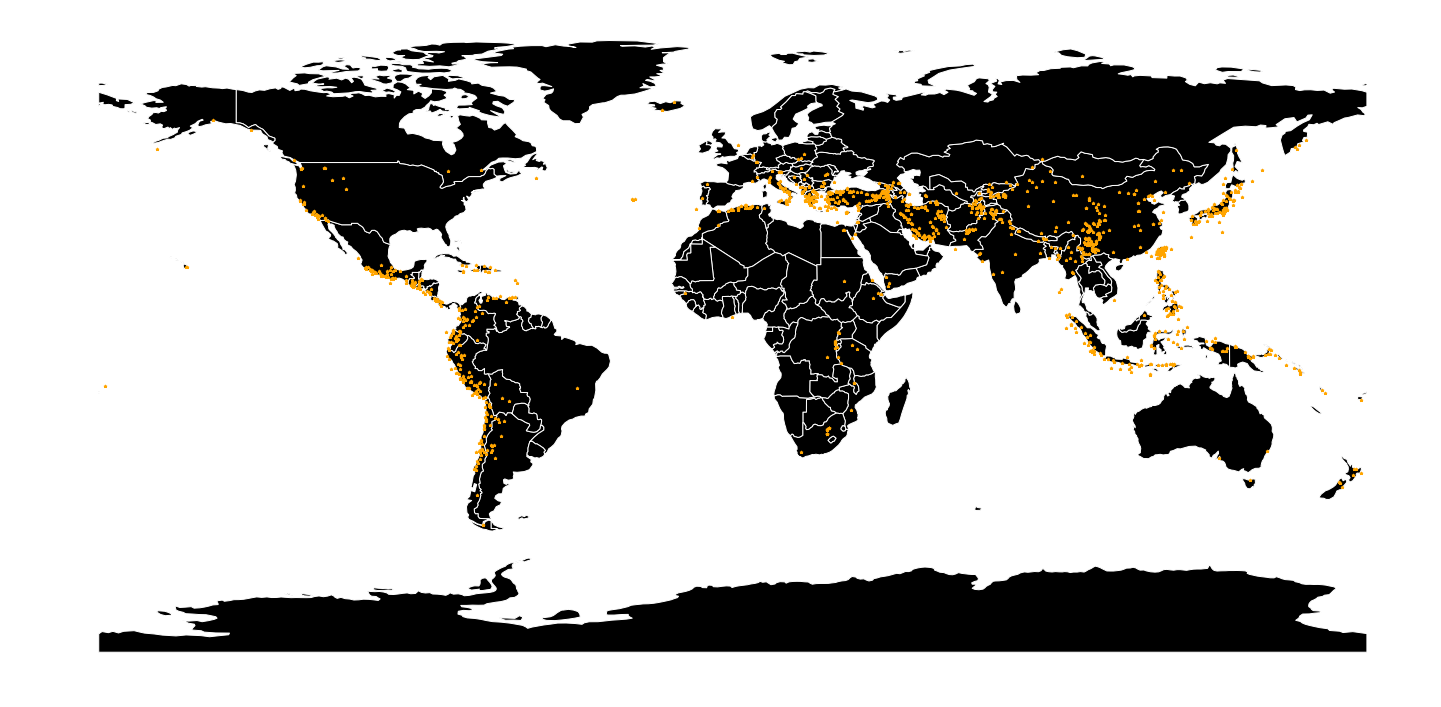

In [20]:
ax = world.plot(color='black', edgecolor='white', figsize=(25,55))
ax.axis('off')
quakes.plot(ax=ax, marker='*', color='orange', markersize=8);